In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
import drms
from datetime import datetime
from sunpy.map import Map
import matplotlib.pyplot as plt
import numpy as np
import torch

import argparse
from neuralop.models import UNO
from skimage.transform import resize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
jsoc_email = "mgjeon@khu.ac.kr"

year = 2011
month = 2
day = 15
hour = 0
minute = 0

duration = "1m"

start_time = datetime(year, month, day, hour, minute)
start_time = start_time.isoformat('_', timespec='seconds')
start_time

'2011-02-15_00:00:00'

In [3]:
client = drms.Client(email=jsoc_email, verbose=True)

In [4]:
find_ar = client.query('hmi.Mharp_720s[][%sZ]' % start_time,
                        key = ["NOAA_AR", "HARPNUM"])
find_ar

,NOAA_AR,HARPNUM
0,11157,364
1,11156,367
2,0,369
3,11159,371
4,0,372
5,11158,377
6,0,378
7,0,380
8,0,381
9,11160,384


In [5]:
find_ar.iloc[5]

NOAA_AR    11158
HARPNUM      377
Name: 5, dtype: int64

In [6]:
harpnum = 377

In [7]:
download_dir = Path("download") / str(harpnum)
download_dir.mkdir(parents=True, exist_ok=True)

In [8]:
series = "sharp_cea_720s"
segments = "Br, Bp, Bt"

ds = 'hmi.%s[%d][%s/%s]{%s}' % \
     (series, harpnum, start_time, duration, segments)

ds

'hmi.sharp_cea_720s[377][2011-02-15_00:00:00/1m]{Br, Bp, Bt}'

In [9]:
# ddir = download_dir / "hmi"
# ddir.mkdir(parents=True, exist_ok=True)
# r = client.export(ds, protocol='fits')
# r.wait()
# result = r.download(ddir) 

In [10]:
# wavelengths = [94,
#                131,
#                171,
#                193,
#                211,
#                304,
#                335,
#                1600,
#                1700]

# for wavelength in wavelengths:
#      ds = 'aia.lev1_euv_12s[%s/%s][%d]{image}' % \
#           (start_time, duration, wavelength)

#      print(ds)
#      ddir = download_dir / f"aia_{wavelength}"
#      ddir.mkdir(parents=True, exist_ok=True)
#      r = client.export(ds, protocol='fits')
#      r.wait()
#      result = r.download(ddir) 

In [11]:
hmi_Bp = Map(str(download_dir / "hmi" / "hmi.sharp_cea_720s.377.20110215_000000_TAI.Bp.fits"))
hmi_Bt = Map(str(download_dir / "hmi" / "hmi.sharp_cea_720s.377.20110215_000000_TAI.Bt.fits"))
hmi_Br = Map(str(download_dir / "hmi" / "hmi.sharp_cea_720s.377.20110215_000000_TAI.Br.fits"))

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


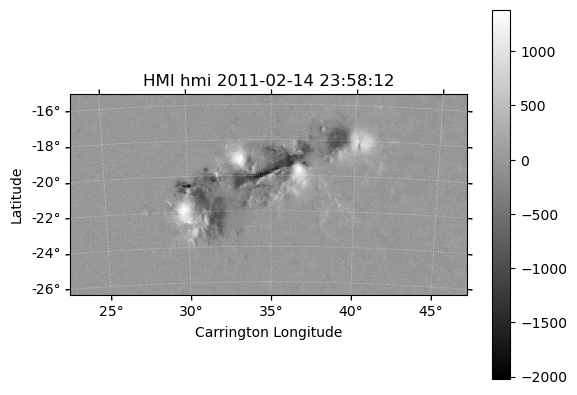

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


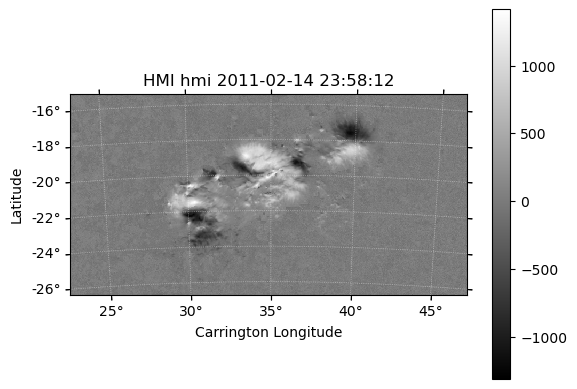

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


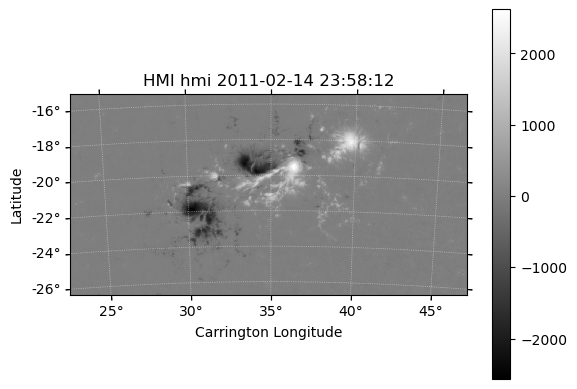

In [12]:
hmi_Bp.peek()
hmi_Bt.peek()
hmi_Br.peek()

In [13]:
Bx = hmi_Bp.data
By = -hmi_Bt.data
Bz = hmi_Br.data

# (ny, nx)
Bz.shape, np.max(np.abs(Bz))

((377, 744), 2617.67)

In [14]:
# (ny, nx, 3)
B = np.stack([Bx, By, Bz], axis=-1).astype(np.float32)
B = resize(B, (256, 512, 3), preserve_range=True)
B.shape, np.max(np.abs(B[..., -1]))

((256, 512, 3), 2606.9604)

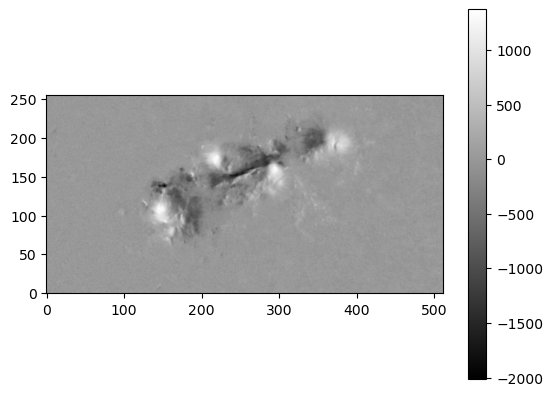

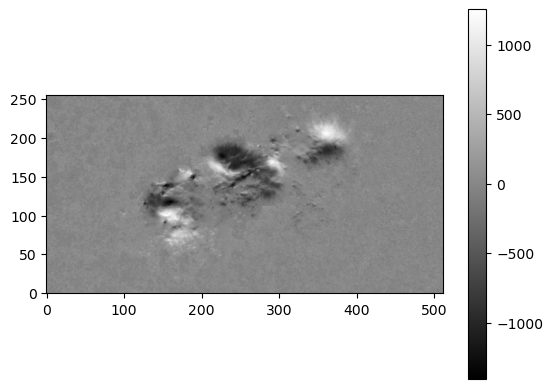

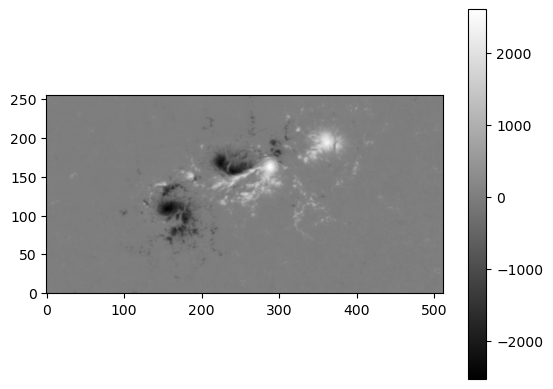

In [15]:
plt.imshow(B[..., 0], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(B[..., 1], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(B[..., 2], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

In [16]:
# (batch, 1, ny, nx, 3)
model_input = torch.from_numpy(B[None, None, ...])
model_input.shape

torch.Size([1, 1, 256, 512, 3])

In [17]:
meta_path = Path("/userhome/jeon_mg/workspace/base/uno_pi_cc_hnorm_unit_aug_ccc_square_energy")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

b_norm = torch.max(torch.abs(model_input)).item()
model_input = model_input / b_norm
model_input = model_input.to(device)

# [batch,   1, 256, 512, 3] -> [batch, 256, 256, 512, 3]
model_output = model(model_input)
# [batch, 256, 256, 512, 3] -> [512, 256, 256, 3]
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi

In [18]:
b.shape

(512, 256, 256, 3)

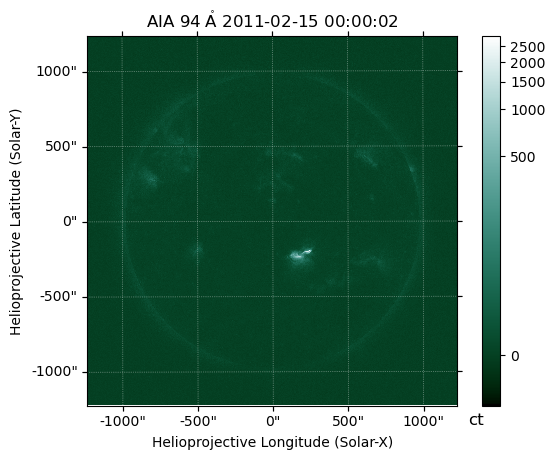

In [40]:
aia_94 = sorted((download_dir / "aia_94").glob("*.fits"))[0]
aia_94 = Map(aia_94)
aia_94.peek()

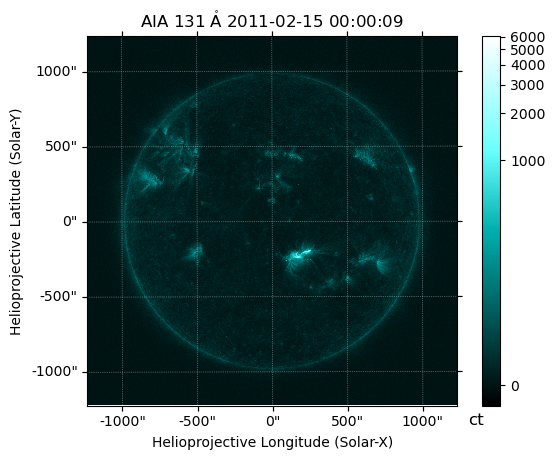

In [41]:
aia_131 = sorted((download_dir / "aia_131").glob("*.fits"))[0]
aia_131 = Map(aia_131)
aia_131.peek()

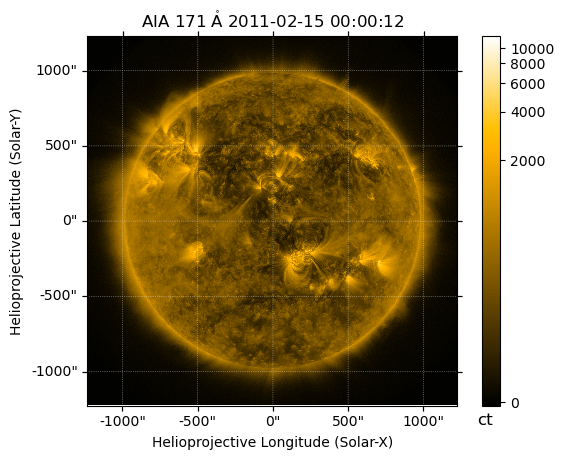

In [42]:
aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171.peek()

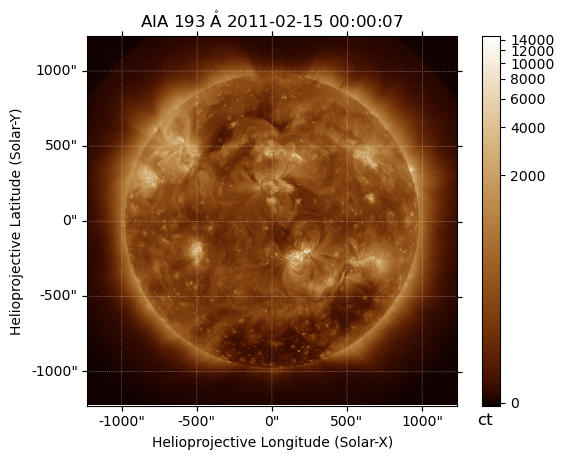

In [43]:
aia_193 = sorted((download_dir / "aia_193").glob("*.fits"))[0]
aia_193 = Map(aia_193)
aia_193.peek()

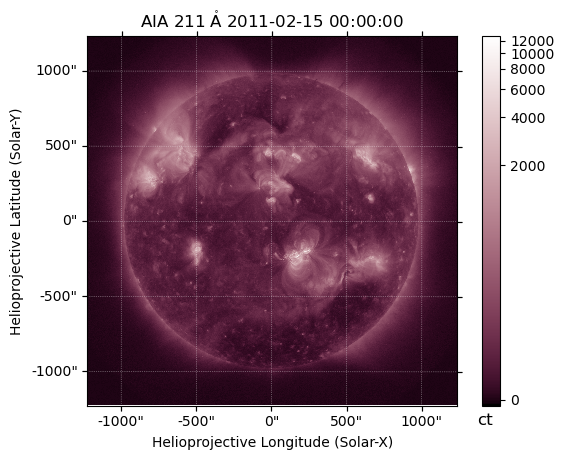

In [44]:
aia_211 = sorted((download_dir / "aia_211").glob("*.fits"))[0]
aia_211 = Map(aia_211)
aia_211.peek()

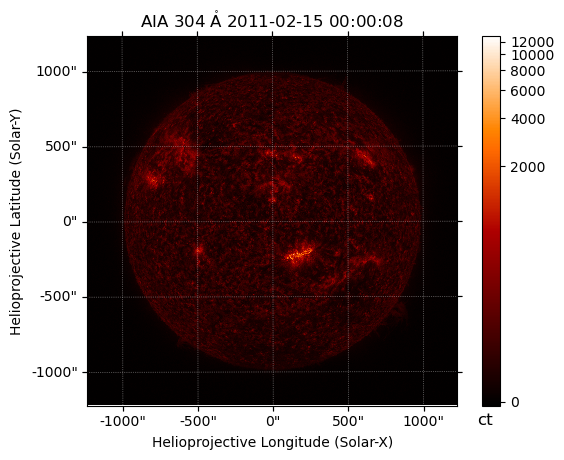

In [46]:
aia_304 = sorted((download_dir / "aia_304").glob("*.fits"))[0]
aia_304 = Map(aia_304)
aia_304.peek()

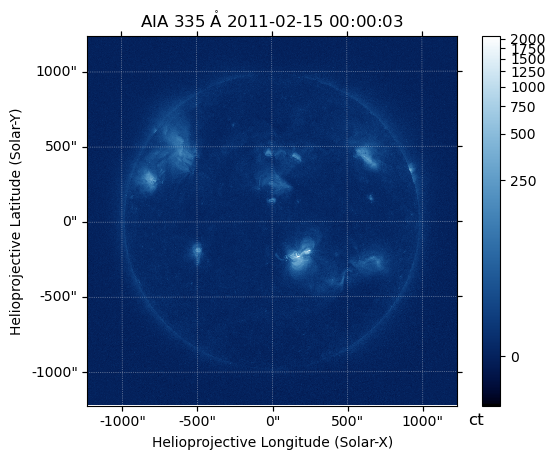

In [47]:
aia_335 = sorted((download_dir / "aia_335").glob("*.fits"))[0]
aia_335 = Map(aia_335)
aia_335.peek()